# Multi-Armed Bandit (k-Armed Bandit)


## References

* https://en.wikipedia.org/wiki/Multi-armed_bandit

In [2]:
from datetime import timedelta, date
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Theory


* Iteratively Selects One of the multiple fixed choices
* These choices are called `arms` or `actions` or `levers`
* Property of each choice is partially known at the time of allocation but become better understood as the time passes.
    * Either we know it earlier (Partially)
    * or we'll know it with time
* these arms are `Independent`
* This algorithm works as `Best Arm Identification`
* Target here is to `Minimize Regret`
* Exploration $\leftrightarrow$ Exploitation

> Objective
>> `Minimize` the sum of rewards earned through a sequence of lever pulls.
>>
>> Each machines provides a random reward from a probability distribution specific to the machine(not known apriori)



## Example

* Lets say a player enters a casino to play slot machines.
* there are 10 machines, but not all machines have same reward (win %) per gamble.
* Now the player had 

## Actions/ Levers

In [3]:
class Levers:
    @staticmethod
    def lever_1(mu=10, sigma=5):
        return np.random.normal(mu, sigma)

    @staticmethod
    def lever_2(mu=8, sigma=3):
        return np.random.normal(mu, sigma)

    @staticmethod
    def lever_3(mu=5, sigma=25):
        return np.random.normal(mu, sigma)

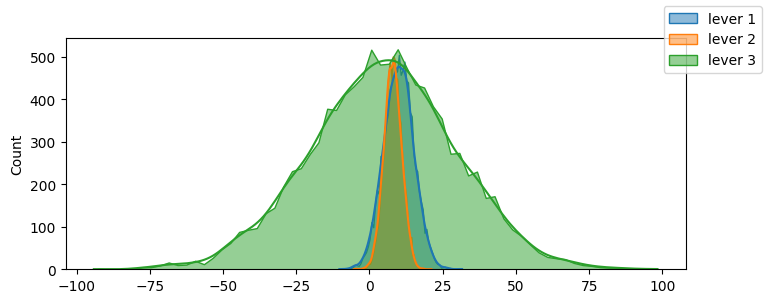

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
sns.histplot([Levers.lever_1() for _ in range(10000)], kde=True, element='poly', label='lever 1', ax=ax)
sns.histplot([Levers.lever_2() for _ in range(10000)], kde=True, element='poly', label='lever 2', ax=ax)
sns.histplot([Levers.lever_3() for _ in range(10000)], kde=True, element='poly', label='lever 3', ax=ax)
fig.legend()
fig.show()

## Reward & Regret

In [3]:
def get_metrics(rewards):
    rewarddf = pd.DataFrame(rewards)
    rewarddf.insert(0, column="reward_cumsum", value=rewarddf["reward"].cumsum())
    aggdf = rewarddf.groupby(by=["lever", "decision"], as_index=False).agg(
        {"reward": ["count", "sum", "min", "max", "mean", "std"]}
    )
    max_reward = aggdf["reward"]["mean"].max()
    max_reward_lever_record = aggdf[aggdf["reward"]["mean"] == max_reward]
    chosen_lever = max_reward_lever_record["lever"].iloc[0]
    return (rewarddf, aggdf, chosen_lever)

In [4]:
def get_regret(rewarddf, aggdf, n_iterations):
    max_reward = aggdf["reward"]["mean"].max()
    optimum_reward = max_reward * n_iterations
    actual_reward = rewarddf["reward"].sum()
    regret = optimum_reward - actual_reward
    return optimum_reward, actual_reward, regret

In [5]:
def plot_reward(rewarddf, x="ts"):
    rewarddf["decision-lever"] = rewarddf["decision"] + "-" + rewarddf["lever"]
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))

    sns.lineplot(data=rewarddf, x=x, y="reward", ax=ax[0], alpha=0.6, color="grey", linewidth=0.5)
    sns.scatterplot(data=rewarddf, x=x, y="reward", hue="decision-lever", ax=ax[0])

    sns.lineplot(data=rewarddf,x=x,y="reward_cumsum",ax=ax[1],alpha=0.6,color="grey",linewidth=0.5)
    sns.scatterplot(data=rewarddf, x=x, y="reward_cumsum", hue="decision-lever", ax=ax[1])

    fig.autofmt_xdate(rotation=45)
    fig.tight_layout()

## Exploration & Exploitation

In [6]:
class Decision:
    def __init__(self, levers) -> None:
        self.ts_idx = date(2024, 1, 1)
        self.seq_idx = 0
        self.decision_idx = 0
        self.rewards = {}
        self.levers = levers
        self.chosen_lever = None

    def get_decision_idx(self, decision):
        if (
            len(self.rewards) == 0
            or self.rewards[len(self.rewards)][-1]["decision"] != decision
        ):
            self.decision_idx += 1
        return self.decision_idx

    def get_lever(self):
        if self.chosen_lever is None:
            if len(self.rewards) == 0:
                raise ValueError("First run explore to get some data")

            rewards = self.rewards[len(self.rewards)]
            _, _, self.chosen_lever = get_metrics(rewards=rewards)
        return self.chosen_lever

    def update_rewards(self, reward_payload, decision_idx):
        if decision_idx not in self.rewards.keys():
            self.rewards[decision_idx] = []
        self.rewards[decision_idx].append(reward_payload)

    def explore(self, enforce_lever=None):
        self.chosen_lever = None
        explore_lever = enforce_lever or np.random.choice(self.levers)
        reward = getattr(Levers, explore_lever)()

        self.ts_idx += timedelta(days=1)
        self.seq_idx += 1

        decision = "explore"
        decision_idx = self.get_decision_idx(decision)
        self.update_rewards(
            reward_payload={
                "decision_idx": decision_idx,
                "decision": decision,
                "seq": self.seq_idx,
                "ts": self.ts_idx,
                "lever": explore_lever,
                "reward": reward,
            },
            decision_idx=decision_idx,
        )

    def exploit(self):
        chosen_lever = self.get_lever()
        reward = getattr(Levers, chosen_lever)()

        self.ts_idx += timedelta(days=1)
        self.seq_idx += 1

        decision = "exploit"
        decision_idx = self.get_decision_idx(decision)
        self.update_rewards(
            reward_payload={
                "decision_idx": decision_idx,
                "decision": decision,
                "seq": self.seq_idx,
                "ts": self.ts_idx,
                "lever": chosen_lever,
                "reward": reward,
            },
            decision_idx=decision_idx,
        )

    @property
    def combine_rewards(self):
        combine_rewards = []
        for key in self.rewards:
            combine_rewards.extend(self.rewards[key])
        combine_rewards
        return combine_rewards

## Only Exploration


In [7]:
decision = Decision(["lever_1", "lever_2", "lever_3"])

for i in range(300):
    decision.explore()

In [8]:
exploration_rewards = decision.combine_rewards
explore_rewarddf, explore_aggdf, _ = get_metrics(exploration_rewards)

In [9]:
explore_rewarddf.head()

,reward_cumsum,decision_idx,decision,seq,ts,lever,reward
0,-32.179189,1,explore,1,2024-01-02,lever_3,-32.179189
1,-31.195799,1,explore,2,2024-01-03,lever_1,0.983390
2,-41.145734,1,explore,3,2024-01-04,lever_3,-9.949936
3,-34.303242,1,explore,4,2024-01-05,lever_2,6.842492
4,-27.017742,1,explore,5,2024-01-06,lever_2,7.285500


In [10]:
explore_aggdf

lever decision reward                                                \
                     count          sum        min        max       mean   
0  lever_1  explore     96  1056.504869   0.689720  27.258263  11.005259   
1  lever_2  explore     94   738.200359   1.127114  15.993774   7.853195   
2  lever_3  explore    110   706.675373 -65.278361  79.247595   6.424322   

              
         std  
0   5.076559  
1   2.913167  
2  27.815116

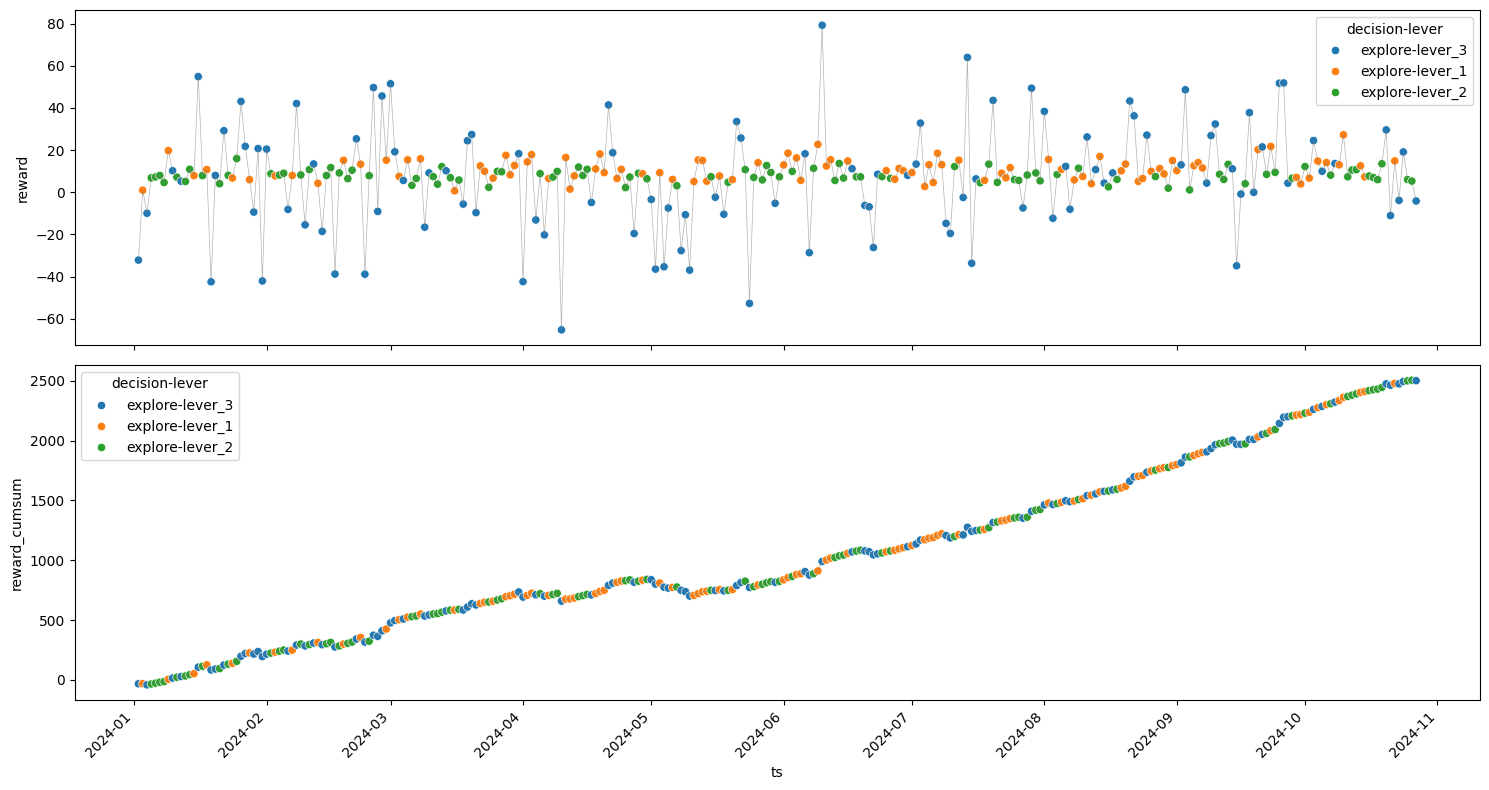

In [11]:
plot_reward(explore_rewarddf)

In [12]:
optimum_reward, actual_reward, regret = get_regret(
    explore_rewarddf, explore_aggdf, n_iterations=300
)
optimum_reward, actual_reward, regret

(3301.5777151820494, 2501.380600210622, 800.1971149714273)

## Only Exploitation


In [13]:
decision = Decision(["lever_1", "lever_2", "lever_3"])

In [14]:
decision.explore("lever_1")
decision.explore("lever_2")
decision.explore("lever_3")


In [15]:
for i in range(297):
    decision.exploit()
    
exploit_rewarddf, exploit_aggdf, _ = get_metrics(decision.combine_rewards)

In [16]:
exploit_aggdf

lever decision reward                                                \
                     count          sum        min        max       mean   
0  lever_1  exploit    297  2968.936025  -1.168535  26.491699   9.996418   
1  lever_1  explore      1    17.075148  17.075148  17.075148  17.075148   
2  lever_2  explore      1    10.819879  10.819879  10.819879  10.819879   
3  lever_3  explore      1     3.680499   3.680499   3.680499   3.680499   

             
        std  
0  4.788448  
1       NaN  
2       NaN  
3       NaN

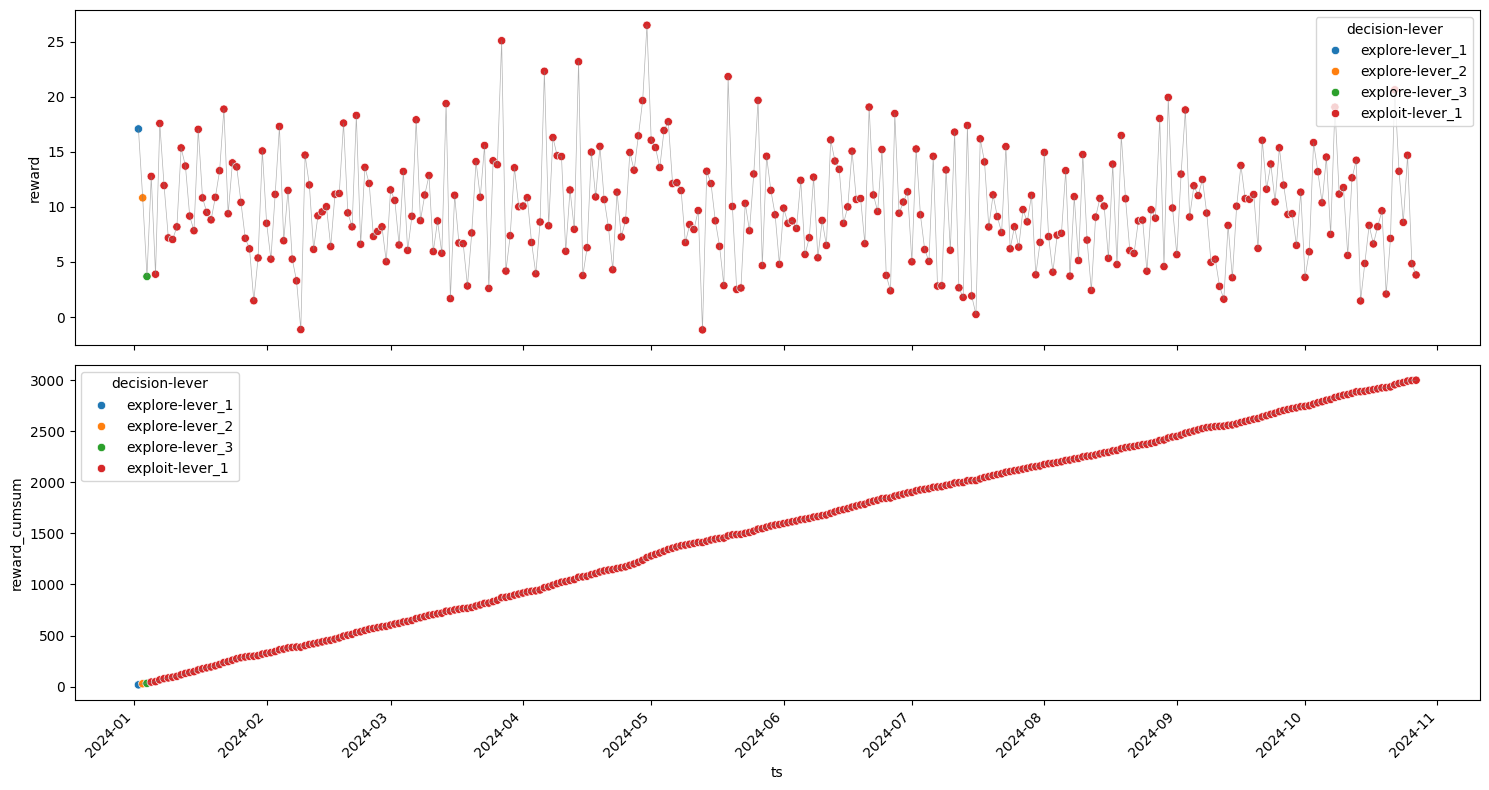

In [17]:
plot_reward(exploit_rewarddf)

In [18]:
optimum_reward, actual_reward, regret = get_regret(
    exploit_rewarddf, exploit_aggdf, n_iterations=300
)
optimum_reward, actual_reward, regret

(5122.544303490573, 3000.511549621074, 2122.0327538694987)

## Alternative Sequentially Exploration & Exploitation


In [19]:
def explore_exploit(
    n_iterations=300,
    explore_iters=10,
    exploit_iters=10,
    levers=["lever_1", "lever_2", "lever_3"],
):

    decision = Decision(levers)
    run_explore = True

    explore_counter, exploit_counter = 0, 0

    for i in range(n_iterations):
        if run_explore:
            decision.explore()
            explore_counter += 1
        else:
            decision.exploit()
            exploit_counter += 1

        if explore_counter == explore_iters:
            run_explore = False
            explore_counter = 0

        if exploit_counter == exploit_iters:
            run_explore = True
            exploit_counter = 0

    return decision.rewards, decision.combine_rewards

(3170.4200612000395, 2011.826176911793, 1158.5938842882465)

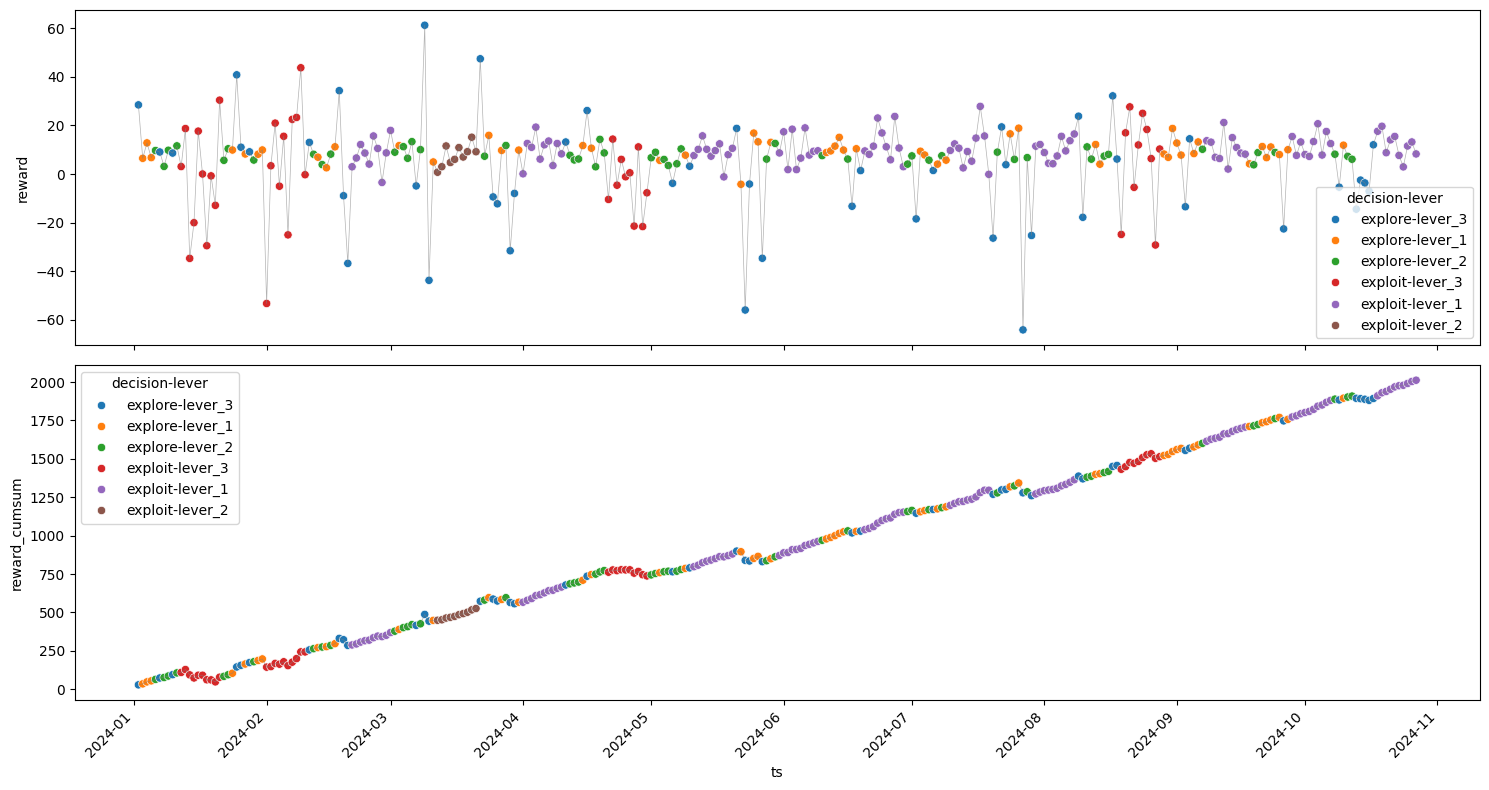

In [20]:
experiment_rewards, experiment_combine_rewards = explore_exploit(
    n_iterations=300,
    explore_iters=10,
    exploit_iters=10,
    levers=["lever_1", "lever_2", "lever_3"],
)
rewarddf, aggdf, _ = get_metrics(experiment_combine_rewards)
plot_reward(rewarddf)

optimum_reward, actual_reward, regret = get_regret(
    rewarddf, aggdf, n_iterations=300
)
optimum_reward, actual_reward, regret

(3198.890157335247, 2510.1438235556516, 688.7463337795953)

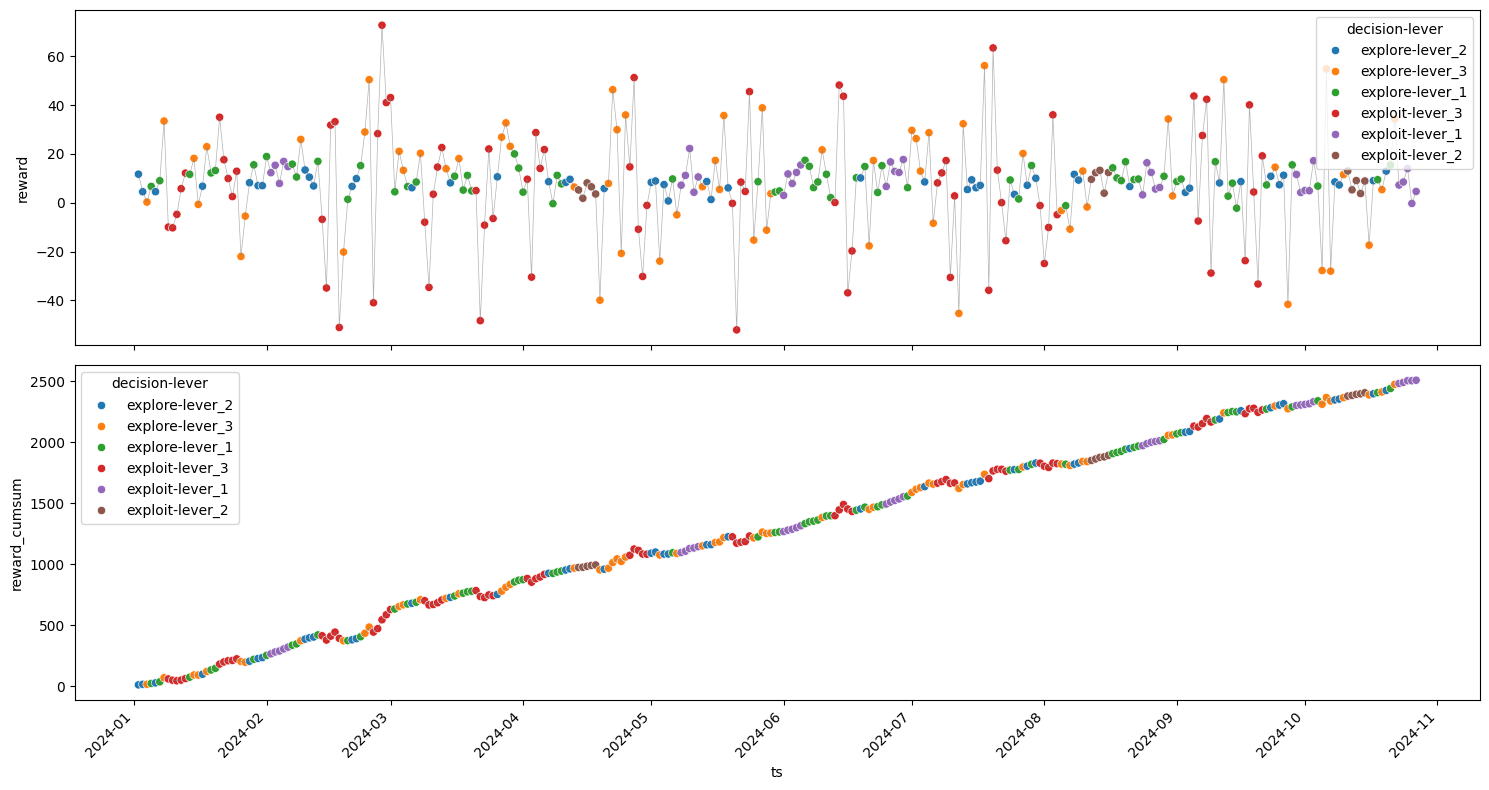

In [21]:
experiment_rewards, experiment_combine_rewards = explore_exploit(
    n_iterations=300,
    explore_iters=7,
    exploit_iters=5,
    levers=["lever_1", "lever_2", "lever_3"],
)
rewarddf, aggdf, _ = get_metrics(experiment_combine_rewards)
plot_reward(rewarddf, "ts")


optimum_reward, actual_reward, regret = get_regret(
    rewarddf, aggdf, n_iterations=300
)
optimum_reward, actual_reward, regret

(3083.7762250652645, 1885.934155474831, 1197.8420695904335)

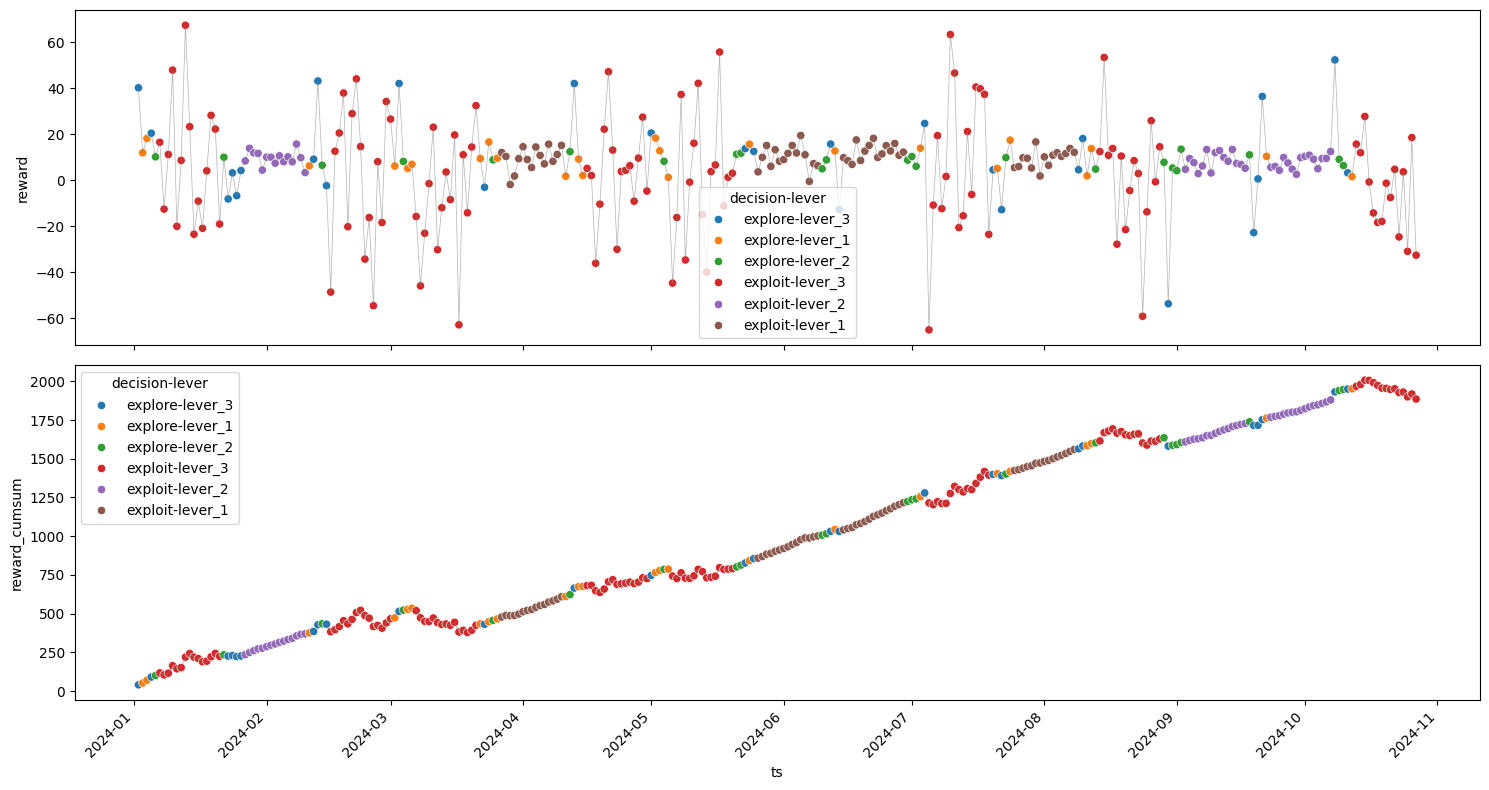

In [22]:
experiment_rewards, experiment_combine_rewards = explore_exploit(
    n_iterations=300,
    explore_iters=5,
    exploit_iters=15,
    levers=["lever_1", "lever_2", "lever_3"],
)
rewarddf, aggdf, _ = get_metrics(experiment_combine_rewards)
plot_reward(rewarddf, "ts")


optimum_reward, actual_reward, regret = get_regret(
    rewarddf, aggdf, n_iterations=300
)
optimum_reward, actual_reward, regret

## Epsilon($\epsilon$) Greedy